In [17]:
import joblib
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import Dataset, DataLoader
import torch
import zipfile
import time

In [18]:
# Unzip the train set
with zipfile.ZipFile('/kaggle/input/ifood-2019-fgvc6/train_set.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/train_set')

# Unzip the validation set
with zipfile.ZipFile('/kaggle/input/ifood-2019-fgvc6/val_set.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/val_set')

# Verify the unzipped directories
print("Contents of /kaggle/working/train_set:")
print(os.listdir('/kaggle/working/train_set')[:10])  # Show only the first 10 entries

print("Contents of /kaggle/working/val_set:")
print(os.listdir('/kaggle/working/val_set')[:10])  # Show only the first 10 entries


Contents of /kaggle/working/train_set:
['train_set']
Contents of /kaggle/working/val_set:
['val_set']


In [24]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Define the paths to the unzipped data
train_dir = '/kaggle/working/train_set/train_set/'
test_dir = '/kaggle/working/val_set/val_set/'

# Load labels
train_labels = pd.read_csv('/kaggle/input/ifood-2019-fgvc6/train_labels.csv')
test_labels = pd.read_csv('/kaggle/input/ifood-2019-fgvc6/val_labels.csv')

# Ensure img_name has the correct extension and create the full img_path
train_labels['img_name'] = train_labels['img_name'].apply(lambda x: x if x.endswith('.jpg') else x + '.jpg')
train_labels['img_path'] = train_labels['img_name'].apply(lambda x: os.path.join(train_dir, x))

test_labels['img_name'] = test_labels['img_name'].apply(lambda x: x if x.endswith('.jpg') else x + '.jpg')
test_labels['img_path'] = test_labels['img_name'].apply(lambda x: os.path.join(test_dir, x))

# Split the training data into training and validation sets
train_labels, val_labels = train_test_split(train_labels, test_size=0.15, random_state=42)

print("Number of train Images", len(train_labels))
print("Number of validation Images", len(val_labels))
print("Number of test Images", len(test_labels))


Number of train Images 100703
Number of validation Images 17772
Number of test Images 11994


In [25]:
# Preprocessing
def preprocess_image(image_path, target_size=(224, 224)):
    if not os.path.exists(image_path):
        return None
    
    # Read the image using OpenCV
    image = cv2.imread(image_path)
    
    if image is None:
        return None
    
    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Resize the image
    image = cv2.resize(image, target_size)
    
    # Normalize the image
    image = image / 255.0
    
    return image

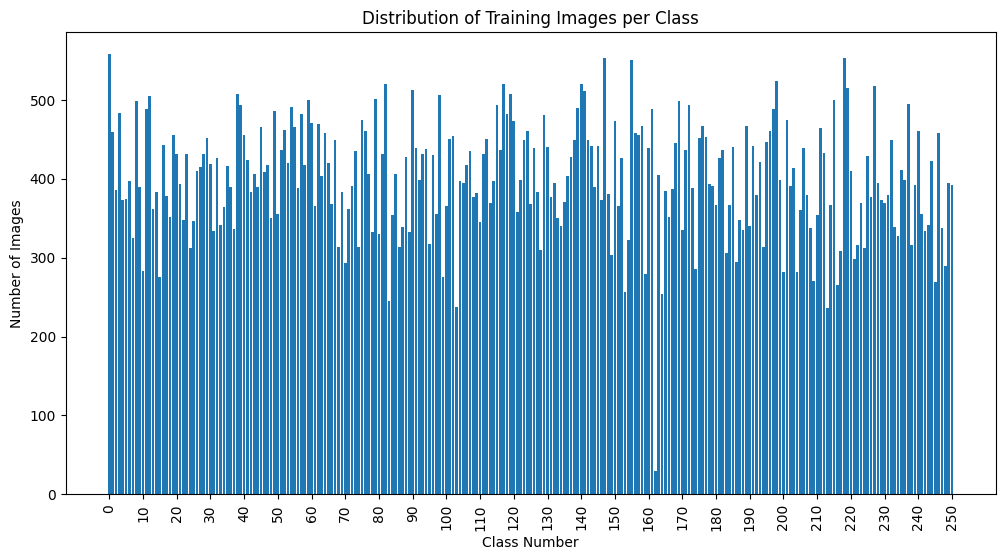

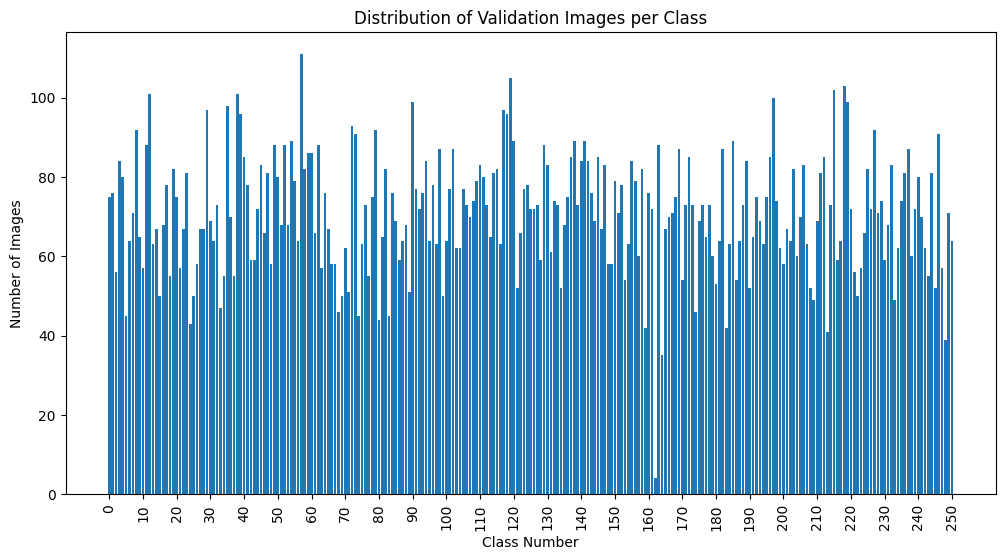

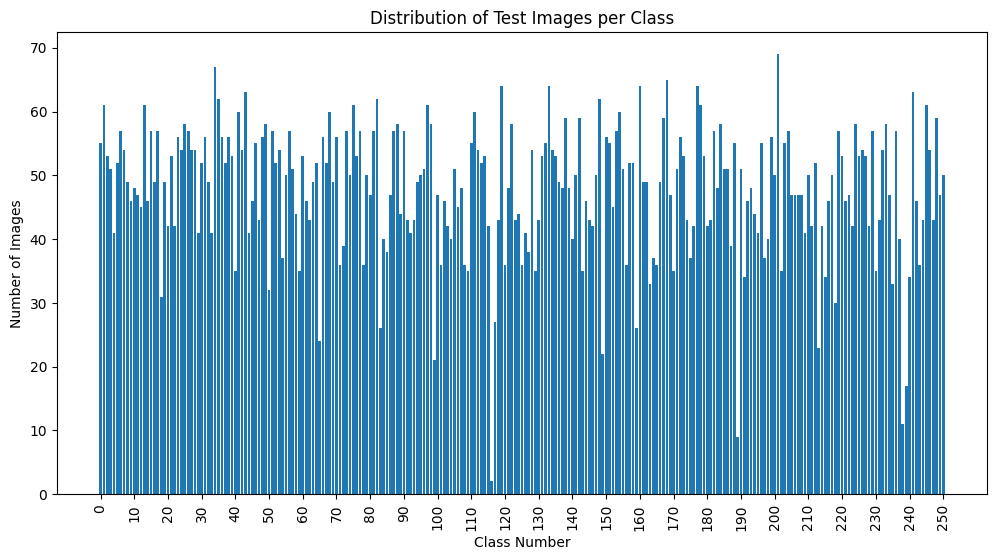

In [2]:
# Plotting the distribution of training images per class with class numbers
plt.figure(figsize=(12, 6))
train_class_counts = train_labels['label'].value_counts().sort_index()
plt.bar(range(len(train_class_counts)), train_class_counts)
plt.title('Distribution of Training Images per Class')
plt.xlabel('Class Number')
plt.ylabel('Number of Images')
plt.xticks(range(0, len(train_class_counts), 10), rotation=90)  # Adjust the step size as needed
plt.show()

# Plotting the distribution of validation images per class with class numbers
plt.figure(figsize=(12, 6))
val_class_counts = val_labels['label'].value_counts().sort_index()
plt.bar(range(len(val_class_counts)), val_class_counts)
plt.title('Distribution of Validation Images per Class')
plt.xlabel('Class Number')
plt.ylabel('Number of Images')
plt.xticks(range(0, len(val_class_counts), 10), rotation=90)  # Adjust the step size as needed
plt.show()

# Plotting the distribution of test images per class with class numbers
plt.figure(figsize=(12, 6))
test_class_counts = test_labels['label'].value_counts().sort_index()
plt.bar(range(len(test_class_counts)), test_class_counts)
plt.title('Distribution of Test Images per Class')
plt.xlabel('Class Number')
plt.ylabel('Number of Images')
plt.xticks(range(0, len(test_class_counts), 10), rotation=90)  # Adjust the step size as needed
plt.show()

Sample image path: /kaggle/working/train_set/train_set/train_116593.jpg
File exists: /kaggle/working/train_set/train_set/train_116593.jpg
Original image read successfully.


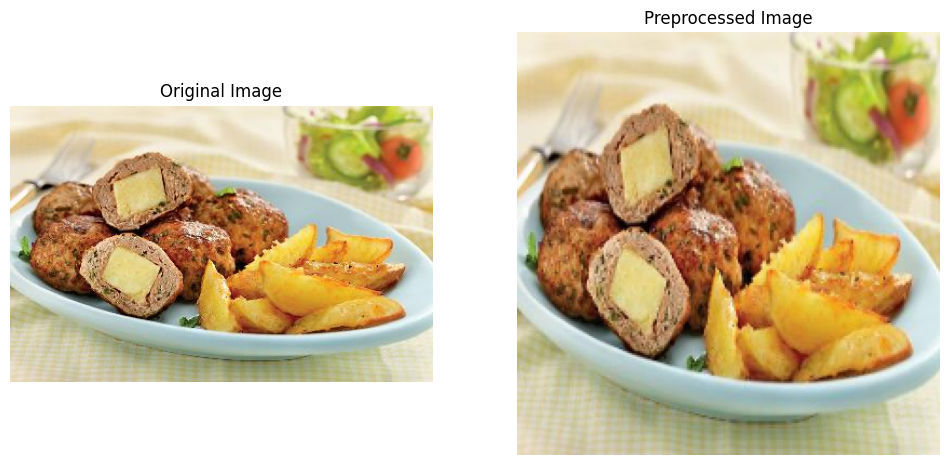

In [32]:
# Load and preprocess a sample image
sample_image_path = train_labels.iloc[10]['img_path']
print(f"Sample image path: {sample_image_path}")

# Check if the file exists
if os.path.exists(sample_image_path):
    print(f"File exists: {sample_image_path}")
else:
    print(f"File does not exist: {sample_image_path}")

# Attempt to read the original image
try:
    original_image = cv2.cvtColor(cv2.imread(sample_image_path), cv2.COLOR_BGR2RGB)
    if original_image is not None:
        print("Original image read successfully.")
    else:
        print("Failed to read the original image.")
except Exception as e:
    print(f"Error reading image: {e}")
    original_image = None

preprocessed_image = preprocess_image(sample_image_path)

# Check if images are successfully loaded before plotting
if original_image is not None and preprocessed_image is not None:
    # Show the original and preprocessed images side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(original_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(preprocessed_image)
    axes[1].set_title('Preprocessed Image')
    axes[1].axis('off')

    plt.show()
else:
    print("Could not load images for visualization.")

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch

class FoodDataset(Dataset):
    def __init__(self, labels_df, image_dir, transform=None):
        self.labels_df = labels_df
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = self.labels_df.iloc[idx]['img_name']
        img_path = os.path.join(self.image_dir, img_name)
        image = preprocess_image(img_path)
        label = self.labels_df.iloc[idx, 1]
        
        if image is None:
            return self.__getitem__((idx + 1) % len(self.labels_df))
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


# Create datasets
train_dataset = FoodDataset(train_labels, train_dir)
val_dataset = FoodDataset(val_labels, train_dir)
test_dataset = FoodDataset(test_labels, test_dir)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Example: Fetch a single batch
images, labels = next(iter(train_loader))
print("Batch shape:", images.shape)

In [ ]:
from sklearn.cluster import KMeans

def extract_sift_features(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute((image * 255).astype(np.uint8), None)
    return descriptors

def create_visual_vocabulary(loader, num_batches=100, vocab_size=500):
    all_descriptors = []
    for i, (images, _) in enumerate(loader):
        if i >= num_batches:
            break
        for img in images:
            img_gray = cv2.cvtColor((img.numpy() * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
            descriptors = extract_sift_features(img_gray)
            if descriptors is not None:
                all_descriptors.append(descriptors)
    
    all_descriptors = np.vstack(all_descriptors)
    kmeans = KMeans(n_clusters=vocab_size, random_state=42, n_init=10)
    kmeans.fit(all_descriptors)
    visual_vocabulary = kmeans.cluster_centers_
    return visual_vocabulary, kmeans

# The section is commented because "visual_vocabulary" and "kmeans" found already and saved as file.
# Create visual vocabulary using a subset of training data
# visual_vocabulary, kmeans = create_visual_vocabulary(train_loader, num_batches=100, vocab_size=500)

## Extract visual vocabulary from the kmeans model
# visual_vocabulary = kmeans.cluster_centers_

# Load the kmeans model
kmeans = joblib.load('/kaggle/input/saved-variables/kmeans_model.pkl')
visual_vocabulary = joblib.load('/kaggle/input/saved-variables/visual_vocabulary.pkl')

In [ ]:
# Defining Histogram Building Function
def build_histogram(descriptors, visual_vocabulary, kmeans):
    histogram = np.zeros(len(visual_vocabulary))
    if descriptors is not None:
        predictions = kmeans.predict(descriptors)
        for pred in predictions:
            histogram[pred] += 1
    # Normalize the histogram
    histogram = histogram / np.sum(histogram) if np.sum(histogram) > 0 else histogram
    return histogram

# Defining function of creating BoW's from the Images
def images_to_bow(loader, visual_vocabulary, kmeans, num_batches):
    histograms = []
    labels = []
    for i, (images, lbls) in enumerate(loader):
        if i >= num_batches:
            break
        for img, label in zip(images, lbls):
            img_gray = cv2.cvtColor((img.numpy() * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
            descriptors = extract_sift_features(img_gray)
            histogram = build_histogram(descriptors, visual_vocabulary, kmeans)
            histograms.append(histogram)
            labels.append(label)
    return np.array(histograms), np.array(labels)

In [ ]:
# Convert training images to BoW histograms
X_train_bow, y_train_bow = images_to_bow(train_loader, visual_vocabulary, kmeans, num_batches=len(train_loader))
X_val_bow, y_val_bow = images_to_bow(val_loader, visual_vocabulary, kmeans, num_batches=len(val_loader))

In [ ]:
# Next few sections for saving and loading BoW functions.
import numpy as np

# Save the BoW histograms to .npy files
def save_bow_histograms(X_train_bow, y_train_bow, X_val_bow, y_val_bow, train_file='X_train_bow.npy', val_file='X_val_bow.npy', train_labels_file='y_train_bow.npy', val_labels_file='y_val_bow.npy'):
    np.save(train_file, X_train_bow)
    np.save(train_labels_file, y_train_bow)
    np.save(val_file, X_val_bow)
    np.save(val_labels_file, y_val_bow)

# Save the histograms and labels
save_bow_histograms(X_train_bow, y_train_bow, X_val_bow, y_val_bow)

In [4]:
# Load the BoW histograms from .npy files
def load_bow_histograms(train_file='/kaggle/input/saved-variables/X_train_bow.npy', val_file='/kaggle/input/saved-variables/X_val_bow.npy', train_labels_file='/kaggle/input/saved-variables/y_train_bow.npy', val_labels_file='/kaggle/input/saved-variables/y_val_bow.npy'):
    X_train_bow = np.load(train_file)
    y_train_bow = np.load(train_labels_file)
    X_val_bow = np.load(val_file)
    y_val_bow = np.load(val_labels_file)
    return X_train_bow, y_train_bow, X_val_bow, y_val_bow

# Load the histograms and labels
X_train_bow, y_train_bow, X_val_bow, y_val_bow = load_bow_histograms()

In [ ]:
# Convert test images to BoW histograms (save and load logic can be added similarly for the test set if needed)
X_test_bow, y_test_bow = images_to_bow(test_loader, visual_vocabulary, kmeans, num_batches=len(test_loader))

In [ ]:
# Fnction to save test histograms and labels
def save_test_bow_histograms(X_test_bow, y_test_bow, test_file='X_test_bow.npy', test_labels_file='y_test_bow.npy'):
    np.save(test_file, X_test_bow)
    np.save(test_labels_file, y_test_bow)

# Save the test histograms and labels
save_test_bow_histograms(X_test_bow, y_test_bow)

In [6]:
# Function to load test histograms and labels
def load_test_bow_histograms(test_file='/kaggle/input/saved-variables/X_test_bow.npy', test_labels_file='/kaggle/input/saved-variables/y_test_bow.npy'):
    X_test_bow = np.load(test_file)
    y_test_bow = np.load(test_labels_file)
    return X_test_bow, y_test_bow

# Load the test histograms and labels
X_test_bow, y_test_bow = load_test_bow_histograms()

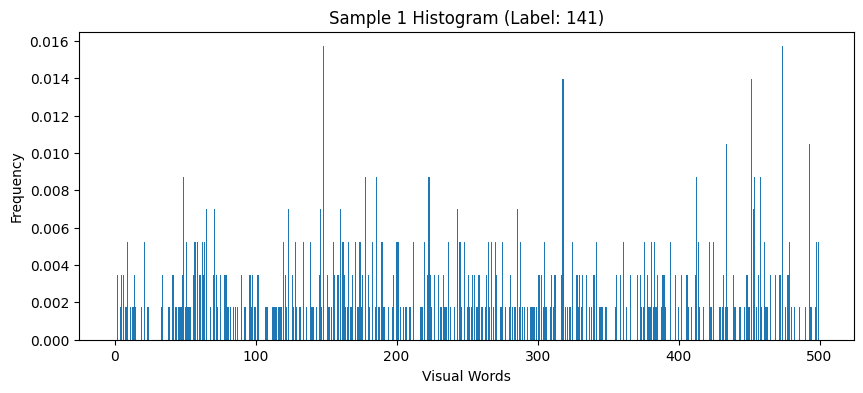

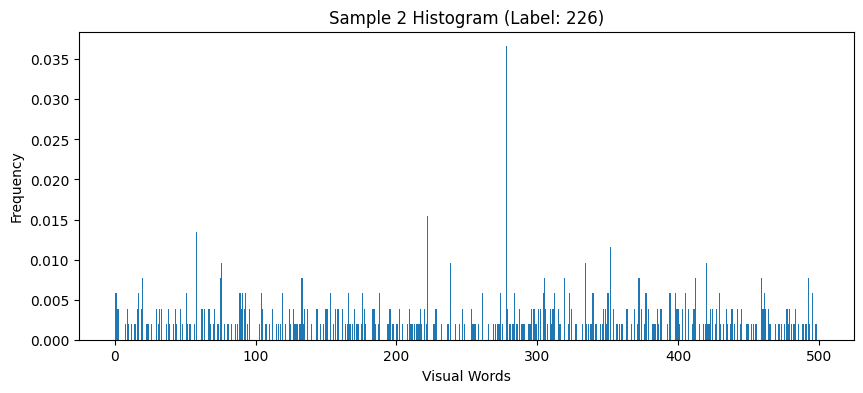

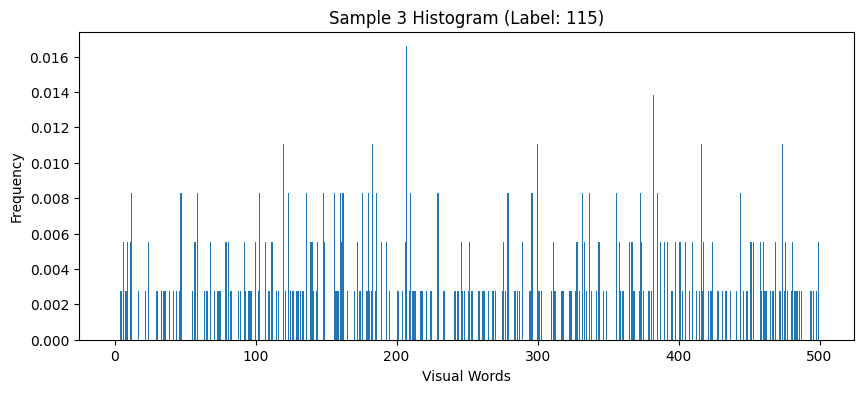

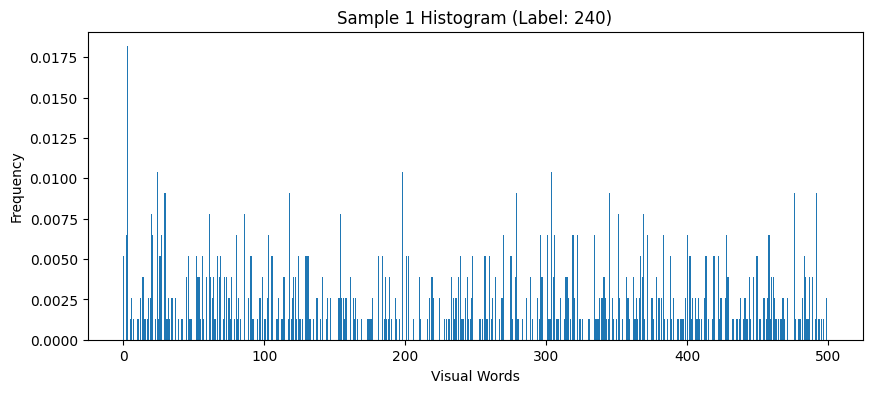

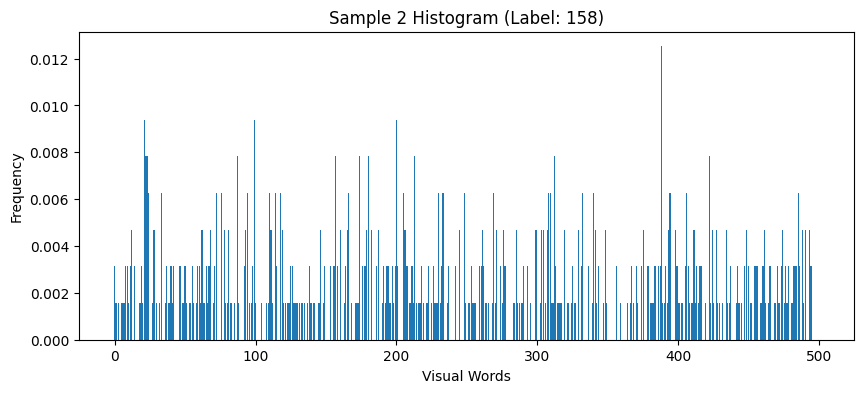

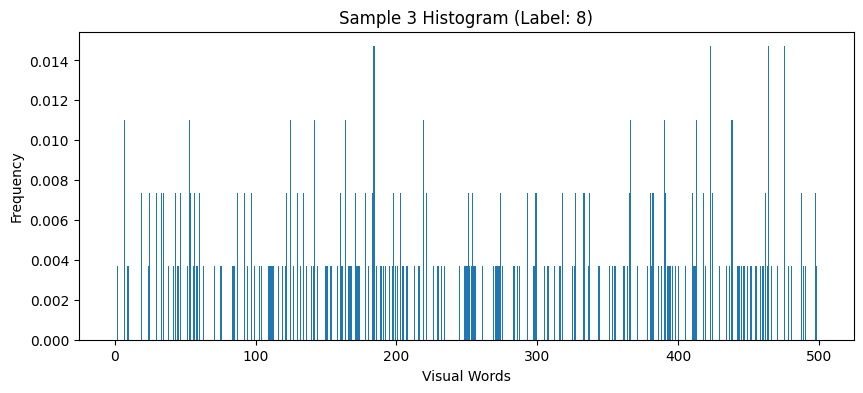

In [11]:
# Function to plot histograms
def plot_histogram(histogram, title):
    plt.figure(figsize=(10, 4))
    plt.bar(range(len(histogram)), histogram)
    plt.title(title)
    plt.xlabel('Visual Words')
    plt.ylabel('Frequency')
    plt.show()

# Plot a few sample histograms from the training set
for i in range(3):
    plot_histogram(X_train_bow[i], f'Sample {i+1} Histogram (Label: {y_train_bow[i]})')

# Plot a few sample histograms from the validation set
for i in range(3):
    plot_histogram(X_val_bow[i], f'Sample {i+1} Histogram (Label: {y_val_bow[i]})')

In [8]:
# Define a small set of parameters to test
param_grid = [
    {'C': 1.0, 'kernel': 'linear'},
    {'C': 1.0, 'kernel': 'rbf'},
]

best_model = None
best_score = 0
best_params = None

# Train and evaluate each model
for params in param_grid:
    print(f"Training with parameters: {params}")
    start_time = time.time()
    
    model = SVC(C=params['C'], kernel=params['kernel'], random_state=42)
    
    # Fit the model
    model.fit(X_train_bow, y_train_bow)
    
    # Predict on the validation set
    y_val_pred = model.predict(X_val_bow)
    
    # Calculate validation metrics
    val_accuracy = accuracy_score(y_val_bow, y_val_pred)
    val_precision = precision_score(y_val_bow, y_val_pred, average='weighted', zero_division=0)
    val_recall = recall_score(y_val_bow, y_val_pred, average='weighted', zero_division=0)
    val_f1 = f1_score(y_val_bow, y_val_pred, average='weighted', zero_division=0)
    
    end_time = time.time()
    
    print(f"Parameters: {params}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Precision: {val_precision:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")
    print(f"Validation F1 Score: {val_f1:.4f}")
    print(f"Training and evaluation time: {end_time - start_time:.2f} seconds")
    print()
    
    # Update the best model if the current one is better
    if val_f1 > best_score:
        best_model = model
        best_score = val_f1
        best_params = params

print(f'Best parameters: {best_params}')
print(f'Best validation F1 Score: {best_score:.4f}')

# Predict on the test set using the best estimator
y_test_pred = best_model.predict(X_test_bow)

# Calculate metrics for test set
test_accuracy = accuracy_score(y_test_bow, y_test_pred)
test_precision = precision_score(y_test_bow, y_test_pred, average='weighted', zero_division=0)
test_recall = recall_score(y_test_bow, y_test_pred, average='weighted', zero_division=0)
test_f1 = f1_score(y_test_bow, y_test_pred, average='weighted', zero_division=0)

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')

# We can't see the results of the {'C': 1.0, 'kernel': 'linear'} because It has been run in another session.

Training with parameters: {'C': 1.0, 'kernel': 'rbf'}
Parameters: {'C': 1.0, 'kernel': 'rbf'}
Validation Accuracy: 0.0697
Validation Precision: 0.0666
Validation Recall: 0.0697
Validation F1 Score: 0.0574
Training and evaluation time: 3630.05 seconds

Best parameters: {'C': 1.0, 'kernel': 'rbf'}
Best validation F1 Score: 0.0574
Test Accuracy: 0.0787
Test Precision: 0.0791
Test Recall: 0.0787
Test F1 Score: 0.0668
